In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [9]:
def read_dataframe(filename, nrows=1000_000):
    # Load only needed columns to avoid memory issues
    cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "PULocationID", "DOLocationID", "trip_distance"]
    df = pd.read_parquet(filename, columns=cols)

    # Sample only a subset of rows (adjust nrows as needed)
    df = df.sample(n=nrows, random_state=42)

    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])

    df["duration"] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df


In [10]:
df_train = read_dataframe("data/yellow_tripdata_2025-01.parquet")
df_val = read_dataframe("data/yellow_tripdata_2025-02.parquet")

In [11]:
len(df_train), len(df_val)

(979522, 979278)

In [15]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)


In [16]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.96576161940915

In [23]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.972679043808089

In [27]:
lr = Ridge(alpha=0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.960296382397646

In [30]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

/tmp/ipykernel_188047/2721475990.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="Prediction", kde=True)
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_188047/2721475990.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an 

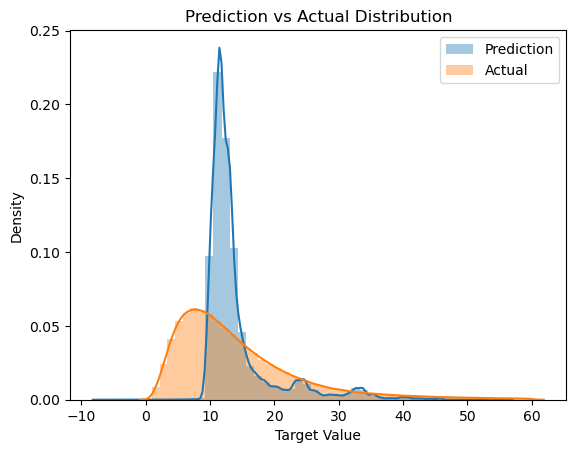

In [28]:
sns.distplot(y_pred, label="Prediction", kde=True)
sns.distplot(y_train, label="Actual", kde=True)
plt.legend()
plt.title("Prediction vs Actual Distribution")
plt.xlabel("Target Value")
plt.show();